In [ ]:
import queue
import networkx as nx

def ejemplo(str):
    return f"Esto es una función de ejemplo: {str}"

class Experimento:
  def __init__(self, grafo, dinamica, metricas=None, calcular_inflacion=None, alpha = 0.5, inflacion=0, long_ciclo=10):
    """
    Inicializa una instancia de la clase Experimento.
    Parámetros
    ----------
    grafo : MultiDiGraph
      Grafo que representa el MIP
    dinamica : Callable
      Función con la siguiente signatura : (aumento, peso_arista, inflacion, alpha)
    duracion_periodo : int, opcional
        La duración de cada período en pasos para actualizar la inflacion, por defecto 10 pasos.
    metricas : Dict(string,Callable), opcional
        Diccionario de con metricas a computar sobre el grafo, ej, {"cantidad_nodos", lambda grafo: len(grafo)}
    calcular_inflacion : Callable, opcional
        Función para calcular la inflación en un período, recibe dos arrays de precios. ej, calc(precios_actual, precios_pasado)
    alpha : float, opcional
        Parametro de ponderacion
        El alpha es CUANTO traslada la inflación.
        Alpha == 1 es lo mismo que la dinamica 2.
        Alpha == 0 es lo mismo que la dinamica 1.
    """
    self.grafo = grafo.copy()
    self.dinamica = dinamica
    self.metricas = metricas or {}
    self._curr_step = 0
    self.metricas_evaluadas = {nombre:[] for nombre in self.metricas}
    self.metricas_evaluadas['inflacion'] = []
    self.queue = queue.Queue() #Fila de tuplas (Nodo, aumento)
    self.precios_periodo_pasado = {}
    self.long_ciclo = long_ciclo
    for nodo in self.grafo.nodes:
      self.precios_periodo_pasado[nodo] = self.grafo.nodes[nodo]['precio']

    self._calc_inflacion = calcular_inflacion or (lambda actual, pasado: 0.0)
    self.inflacion = inflacion # Expresada en %.
    assert 0.0 <= alpha <= 1.0
    self.alpha = alpha

  def shock(self, nodo, aumento):
    precio_actual = self.grafo.nodes[nodo]['precio']
    nuevo_precio = { nodo : { 'precio': (precio_actual * (1 + (aumento/100)))}}
    nx.set_node_attributes(self.grafo, nuevo_precio)
    vecinos = self.grafo[nodo].items()
    aumentos_a_pasar = []
    for vecino in vecinos:
      aumento_vecino = self.actualizar(vecino,aumento)
      aumentos_a_pasar.append(aumento_vecino)
    for i, vecino in enumerate(vecinos):
      self.queue.put((vecino[0], aumentos_a_pasar[i]))

  def step(self, n=1): # aumento pasado en %.

    for _ in range(n):

        self._single_step()
        self._calcular_metricas()
        self._curr_step += 1

  def actualizar(self, vecino, aumento):
    nodo_vecino = vecino[0]
    precio_actual = self.grafo.nodes[nodo_vecino]['precio']
    peso_arista = vecino[1][0]['w']
    aumento_vecino = self.dinamica(aumento, peso_arista,self.inflacion, self.alpha)
    nuevo_precio = {nodo_vecino : {'precio':  (precio_actual * (1 + (aumento_vecino / 100)))}}
    nx.set_node_attributes(self.grafo, nuevo_precio)

    return aumento_vecino

  def _single_step(self):
    self.actualizar_inflacion()

    if not self.queue.empty():
      nodo_actual, aumento = self.queue.get()
      vecinos = self.grafo[nodo_actual].items()
      aumentos_a_pasar = []
      for vecino in vecinos:
        aumento_vecino = self.actualizar(vecino,aumento) #Side effect actualiza ese vecino.
        aumentos_a_pasar.append(aumento_vecino)
      for i, vecino in enumerate(vecinos):
        self.queue.put((vecino[0], aumentos_a_pasar[i]))

  def actualizar_inflacion(self):
      if self._curr_step % self.long_ciclo == 0:
        precios_periodo_actual = {}
        for nodo in self.grafo.nodes:
          precios_periodo_actual[nodo] = self.grafo.nodes[nodo]['precio']

        self.inflacion = self._calc_inflacion(precios_periodo_actual.values(), self.precios_periodo_pasado.values())
        self.precios_periodo_pasado = precios_periodo_actual.copy()

  def _calcular_metricas(self):
    for nombre, metrica in self.metricas.items():
          self.metricas_evaluadas[nombre].append(metrica(self.grafo))
    self.metricas_evaluadas['inflacion'].append(self.inflacion)

  def __str__(self):
      return str(self.to_dict())

  def __repr__(self):
      return str(self)

  def to_dict(self):
      return {"id_grafo": hash(self.grafo), "step": self._curr_step, "metricas": self._metricas_evaluadas}

In [ ]:
# Definimos las dinamicas
def dinamica_1(aumento, peso_arista, inflacion=0.0, alpha=1.0):
    aumento_vecino = aumento * peso_arista
    return aumento_vecino

def dinamica_2(aumento, peso_arista, inflacion=0.0, alpha=1.0):
    aumento_vecino = aumento * (1 + inflacion/100)
    return aumento_vecino

def dinamica_3(aumento, peso_arista, inflacion=0.0, alpha=1.0):
    aumento_vecino = (alpha * inflacion) + ((1 -alpha) * (aumento * peso_arista))
    return aumento_vecino

## Defino como se calcula la inflacion
def calcular_inflacion(precios_periodo_actual, precios_periodo_pasado):
    # Asumimos una inflación no ponderada
    # donde la "canasta" sea un producto de cada sector. Entonces,
    # la canasata es la sumatoria de los precios de todos los sectores, y con eso calculamos IPC e inflación.
    # calculo los precios actuales

    ipc_actual = sum(precios_periodo_actual) / len(precios_periodo_actual)
    ipc_pasado = sum(precios_periodo_pasado) / len(precios_periodo_pasado)
    inflacion = ((ipc_actual / ipc_pasado) - 1)  * 100
    return inflacion

In [ ]:
import itertools as it
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def armar_grafo(dataframe, precios_random=True):
  graph = {}
  for index, row in dataframe.iterrows():
    d = {}
    for (k, v) in row.items():
      d[k] = {"w":v}
    graph[index] = d
  G_base = nx.MultiDiGraph(graph)
  G = nx.MultiDiGraph(graph)
  for (n1,n2,d) in G_base.edges(data=True):
    if d['w'] == 0:
      G.remove_edge(n1,n2)

  nodos = list(G.nodes())
  precios = {}

  nuevo_precio = (lambda : np.random.randint(0,100)) if precios_random else (lambda:100)

  for nodo in nodos:
      precios[nodo] = {'precio': nuevo_precio()}

  nx.set_node_attributes(G, precios)
  return G


def plot_grafo(grafo, labels=True, grande=False, node_data=True,):
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    tamaños = list(grafo.degree())
    for i in range(len(tamaños)):
      tamaños[i] = (tamaños[i][1] ** 2) / 9 if ((tamaños[i][1] ** 2) / 9 ) > 100 else 100
    pos = nx.kamada_kawai_layout(grafo)
    if grande:
      fig, ax = plt.subplots(figsize=(30, 30))
    else:
      fig,ax = plt.subplots(figsize=(10,10))
    plt.axis("off")
    nx.draw_networkx_nodes(grafo, pos, node_size=tamaños, ax = ax)
    nx.draw_networkx_labels(grafo, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(
        grafo, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax, arrows=True, arrowstyle='->',
    )
    if labels:
      labels = {
          tuple(edge): f"{'w'}={round(attrs['w'],3)}"
          for *edge, attrs in grafo.edges(keys=True, data=True)
      }
      nx.draw_networkx_edge_labels(
          grafo,
          pos,
          labels,
          connectionstyle=connectionstyle,
          label_pos=0.3,
          font_color="blue",
          bbox={"alpha": 0},
          ax=ax,
      )
      labels = dict(grafo.nodes(data=True))
      for key in labels:
        labels[key] = labels[key]['precio']
      for key in pos:
        pos[key] = pos[key] + 0.05
      nx.draw_networkx_labels(
          grafo,
          pos,
          labels,
          font_size = 10,
          font_color="red",
          ax=ax,
      )

In [ ]:
import pandas as pd
sectores = ['luz','chapa','campo','chip','comida']

pesos = np.array([[0,0.25,0.1,0,0],[0,0,0,0.7,0.15],[0,0,0,0,0.8],[0,0,0,0,0],[0,0,0,0,0]])
test = pd.DataFrame(data=pesos,columns=sectores,index=sectores)

pesos_ciclo = np.array([[0,0.25,0.1,0,0],[0,0,0,0.7,0.15],[0,0,0,0,0.8],[0.2,0,0,0,0],[0,0,0,0,0]])
test_ciclo = pd.DataFrame(data=pesos_ciclo,columns=sectores,index=sectores)
g_test = armar_grafo(test, precios_random=False)
g_test_ciclo = armar_grafo(test_ciclo, precios_random=False)

In [ ]:
test_ciclo

,luz,chapa,campo,chip,comida
luz,0.0,0.25,0.1,0.0,0.00
chapa,0.0,0.00,0.0,0.7,0.15
campo,0.0,0.00,0.0,0.0,0.80
chip,0.2,0.00,0.0,0.0,0.00
comida,0.0,0.00,0.0,0.0,0.00


0
20.24999999999999
2.6507276507276467
0.999493670886098
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


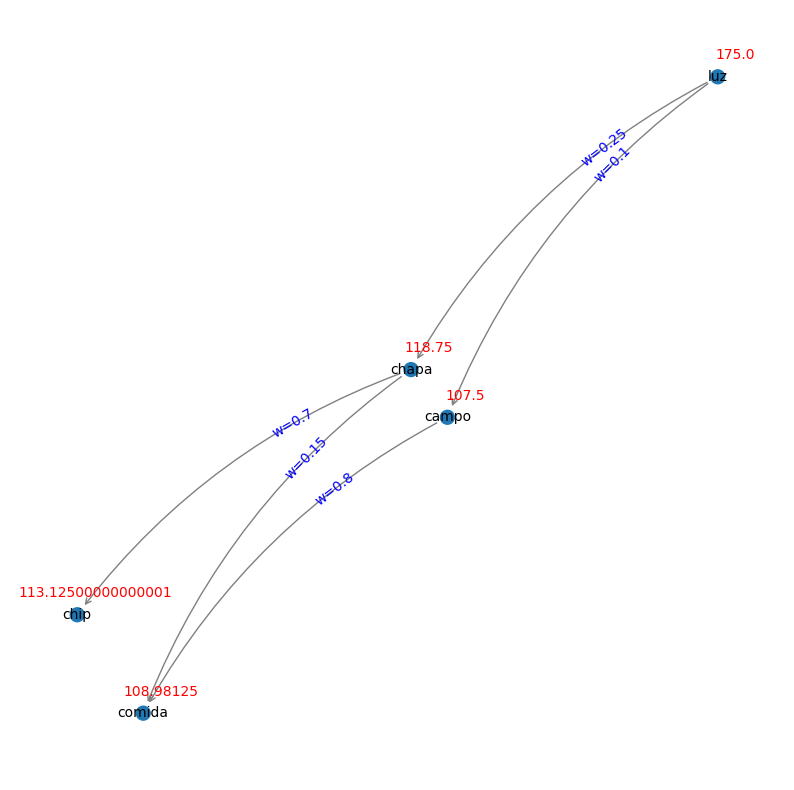

In [ ]:
exp1 = Experimento(g_test,dinamica_1,calcular_inflacion=calcular_inflacion)
exp1.shock('luz',75)
exp1.step(20)
plot_grafo(exp1.grafo)

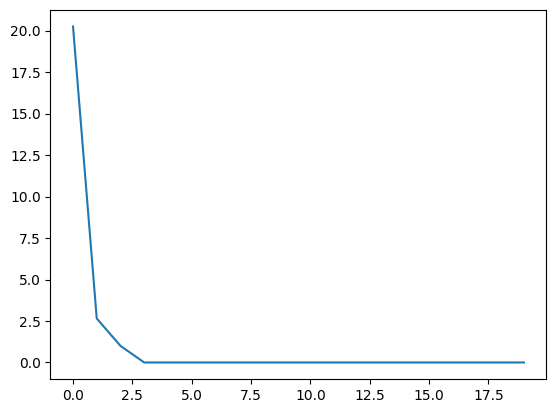

In [ ]:
inflacion_exp1 = exp1.metricas_evaluadas['inflacion']
tiempo = range(0,len(inflacion_exp1))
plt.plot(tiempo,inflacion_exp1)

AUMENTO QUE ENTRA: 75 
 vecino:  ('chapa', AtlasView({0: {'w': 0.25}}))
Aumento vecino:  18.75
AUMENTO QUE ENTRA: 75 
 vecino:  ('campo', AtlasView({0: {'w': 0.1}}))
Aumento vecino:  7.5
INFLACION:  0
AUMENTO QUE ENTRA: 18.75 
 vecino:  ('chip', AtlasView({0: {'w': 0.7}}))
Aumento vecino:  13.125
AUMENTO QUE ENTRA: 18.75 
 vecino:  ('comida', AtlasView({0: {'w': 0.15}}))
Aumento vecino:  2.8125
INFLACION:  20.24999999999999
AUMENTO QUE ENTRA: 7.5 
 vecino:  ('comida', AtlasView({0: {'w': 0.8}}))
Aumento vecino:  6.0
INFLACION:  2.6507276507276467
INFLACION:  0.999493670886098
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0
INFLACION:  0.0


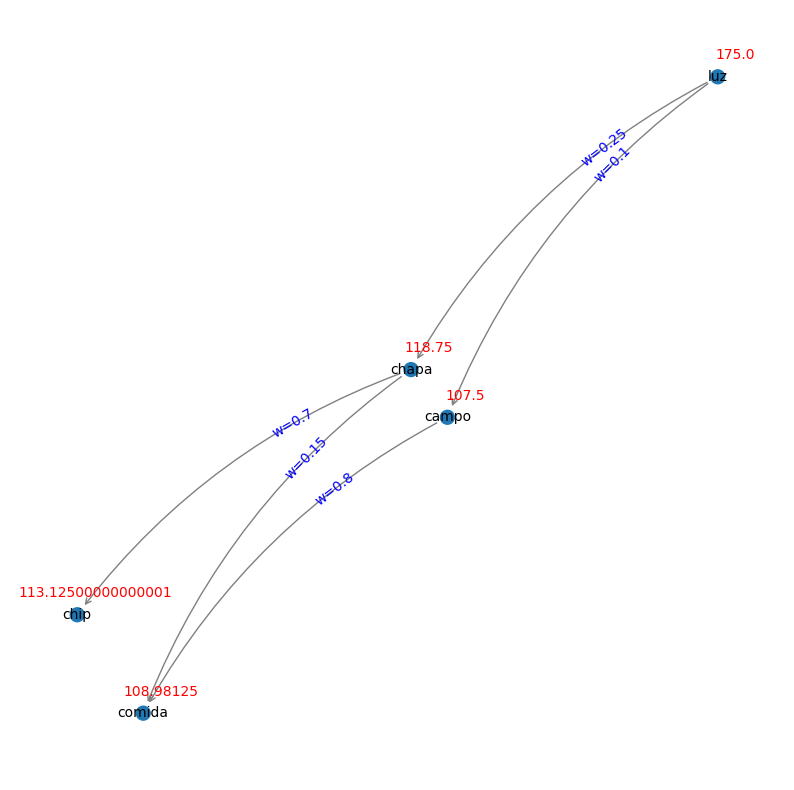

In [ ]:
exp2 = Experimento(g_test,dinamica_1, alpha = 0.3,calcular_inflacion=calcular_inflacion)
exp2.shock('luz',75)
exp2.step(20)
plot_grafo(exp2.grafo)

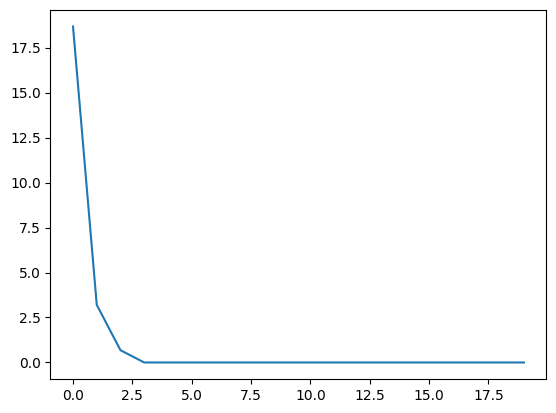

In [ ]:
inflacion_exp2 = exp2.metricas_evaluadas['inflacion']
tiempo = range(0,len(inflacion_exp2))
plt.plot(tiempo,inflacion_exp2)

AUMENTO QUE ENTRA: 75 
 vecino:  ('chapa', AtlasView({0: {'w': 0.25}}))
Aumento vecino:  13.125
AUMENTO QUE ENTRA: 75 
 vecino:  ('campo', AtlasView({0: {'w': 0.1}}))
Aumento vecino:  5.25
INFLACION:  0
AUMENTO QUE ENTRA: 13.125 
 vecino:  ('chip', AtlasView({0: {'w': 0.7}}))
Aumento vecino:  12.033749999999998
AUMENTO QUE ENTRA: 13.125 
 vecino:  ('comida', AtlasView({0: {'w': 0.15}}))
Aumento vecino:  6.980624999999999
AUMENTO QUE ENTRA: 5.25 
 vecino:  ('comida', AtlasView({0: {'w': 0.8}}))
Aumento vecino:  8.542499999999999
AUMENTO QUE ENTRA: 12.033749999999998 
 vecino:  ('luz', AtlasView({0: {'w': 0.2}}))
Aumento vecino:  7.287224999999999
AUMENTO QUE ENTRA: 7.287224999999999 
 vecino:  ('chapa', AtlasView({0: {'w': 0.25}}))
Aumento vecino:  6.877764374999999
AUMENTO QUE ENTRA: 7.287224999999999 
 vecino:  ('campo', AtlasView({0: {'w': 0.1}}))
Aumento vecino:  6.112605749999999
AUMENTO QUE ENTRA: 6.877764374999999 
 vecino:  ('chip', AtlasView({0: {'w': 0.7}}))
Aumento vecino:  8

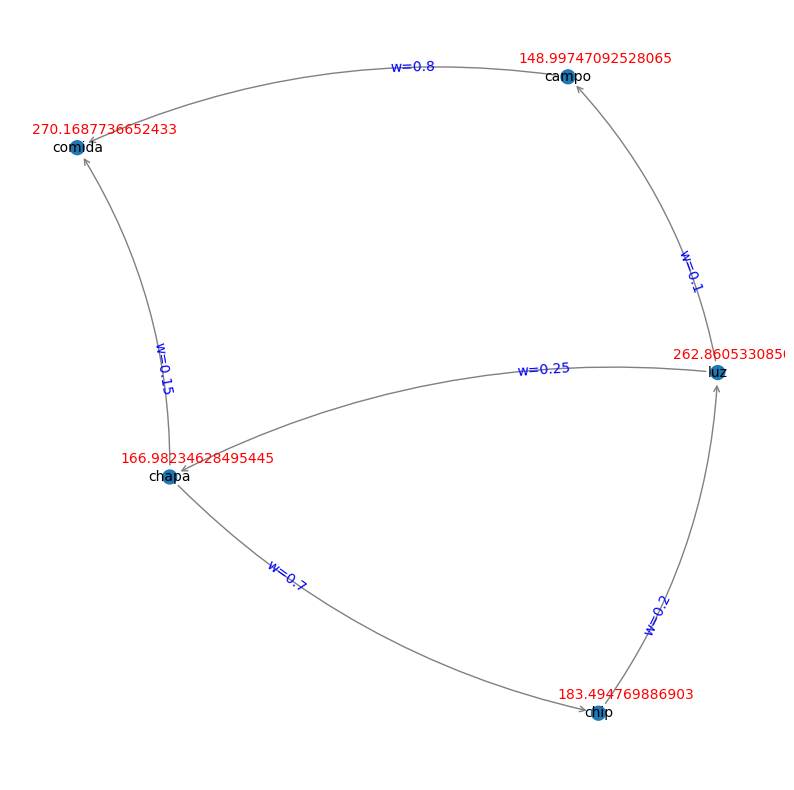

In [ ]:
exp3 = Experimento(g_test_ciclo,dinamica_3, alpha = 0.3,calcular_inflacion=calcular_inflacion)
exp3.shock('luz',75)
exp3.step(50)
plot_grafo(exp3.grafo)

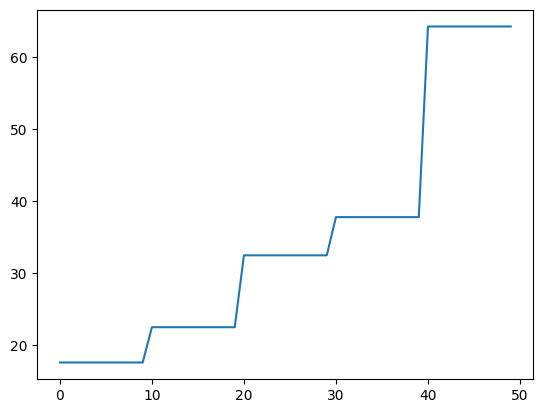

In [ ]:
inflacion_exp3 = exp3.metricas_evaluadas['inflacion']
tiempo = range(0,len(inflacion_exp3))
plt.plot(tiempo,inflacion_exp3)

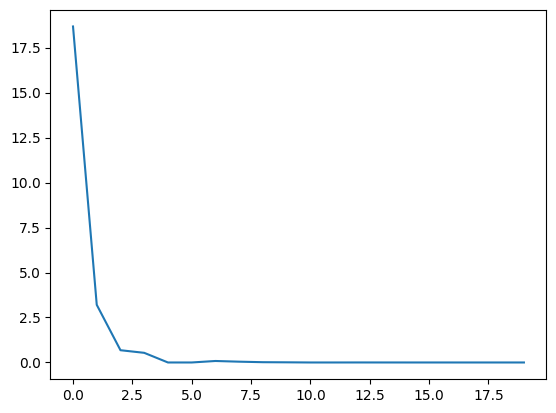

In [ ]:
inflacion_exp3 = exp3.metricas_evaluadas['inflacion']
tiempo = range(0,len(inflacion_exp3))
plt.plot(tiempo,inflacion_exp3)

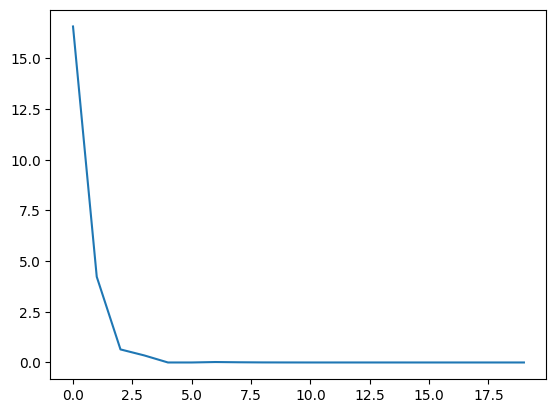

In [ ]:
inflacion_exp4 = exp4.metricas_evaluadas['inflacion']
tiempo = range(0,len(inflacion_exp1))
plt.plot(tiempo,inflacion_exp4)

Probemos con el MIP

In [ ]:
mip = pd.read_csv('/content/MIP, grafo.csv')
mip.set_index('Unnamed: 0',inplace=True,drop=True)
mip_grafo = armar_grafo(mip, precios_random=False)
mip

,"Cultivo de cereales, oleaginosas y forrajeras","Cultivo de hortalizas, legumbres, flores y plantas ornamentales",Cultivo de frutas y nueces,Cultivos industriales,Producción de semillas,"Cría de ganado y producción de leche, lana y pelos",Producción de granja,Servicios agropecuarios,Caza,Silvicultura y extracción de madera,...,Enseñanza pública,Enseñanza privada,Salud humana pública,Salud humana privada,Servicios veterinarios,Servicios sociales,Servicios de saneamiento,Actividad de asociaciones,"Servicios de cine, radio y televisión","Servicios personales, de reparación, actividades deportivas y de esparcimiento"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
"Cultivo de cereales, oleaginosas y forrajeras",0.010319,0.000000,0.021804,0.005831,0.000000,0.152144,0.058182,0.000000,0.000000,0.000000,...,0.0,0.000699,0.0,0.000123,0.002589,0.0,0.000000,0.000000,7.665287e-09,3.667518e-03
"Cultivo de hortalizas, legumbres, flores y plantas ornamentales",0.000000,0.167226,0.013082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.010121,0.0,0.002514,0.000000,0.0,0.000000,0.008649,5.289048e-07,8.638087e-03
Cultivo de frutas y nueces,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.004982,0.0,0.001217,0.000000,0.0,0.000000,0.000000,4.599172e-08,4.729049e-07
Cultivos industriales,0.000000,0.000000,0.000000,0.020212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Producción de semillas,0.097189,0.021008,0.052329,0.007799,0.021740,0.013291,0.001349,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Servicios sociales,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Servicios de saneamiento,0.000004,0.000009,0.000009,0.000004,0.000004,0.000004,0.000005,0.000004,0.000001,0.000006,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Actividad de asociaciones,0.000277,0.000634,0.000573,0.000253,0.000273,0.000254,0.000418,0.000248,0.000073,0.000404,...,0.0,0.000000,0.0,0.125844,0.103975,0.0,0.000000,0.000000,1.514040e-03,0.000000e+00


In [ ]:
list(mip.columns)

['Cultivo de cereales, oleaginosas y forrajeras',
 'Cultivo de hortalizas, legumbres, flores y plantas ornamentales',
 'Cultivo de frutas y nueces',
 'Cultivos industriales',
 'Producción de semillas',
 'Cría de ganado y producción de leche, lana y pelos',
 'Producción de granja',
 'Servicios agropecuarios',
 'Caza',
 'Silvicultura y extracción de madera',
 'Pesca',
 'Extracción de petróleo, gas, carbón y uranio',
 'Extracción de minerales metalíferos',
 'Extracción de otros minerales',
 'Matanza de animales, conservación y procesamiento de carnes',
 'Elaboración y conservación de pescado y productos de pescado',
 'Elaboración y conservación de frutas, legumbres y hortalizas',
 'Aceites y subproductos oleaginosos',
 'Productos lácteos',
 'Molienda de trigo y de otros cereales',
 'Alimentos balanceados',
 'Productos de panadería',
 'Azúcar',
 'Cacao, chocolate y productos de confitería',
 'Pastas alimenticias',
 'Otros productos alimenticios',
 'Bebidas alcohólicas',
 'Producción vitivi

In [ ]:
experimento_mip_1=Experimento(mip_grafo,dinamica_3,calcular_inflacion=calcular_inflacion, alpha=0.45,long_ciclo=5)

In [ ]:
experimento_mip_1.shock('Electricidad',35)
experimento_mip_1.shock('Gas',10)
experimento_mip_1.step(200)
experimento_mip_1.step(200)
inflacion_exp_mip = experimento_mip_1.metricas_evaluadas['inflacion']

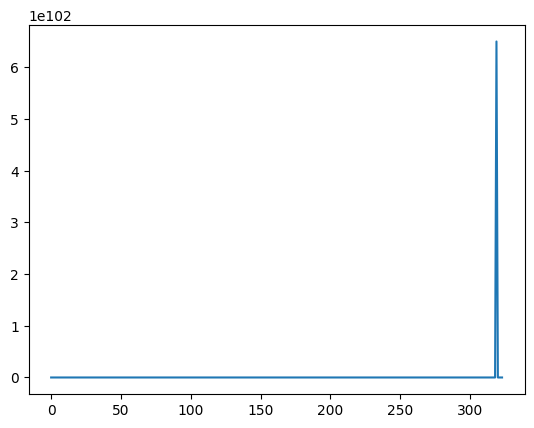

In [ ]:
tiempo = range(0,len(inflacion_exp_mip))
plt.plot(tiempo[:-1],np.diff((inflacion_exp_mip)))

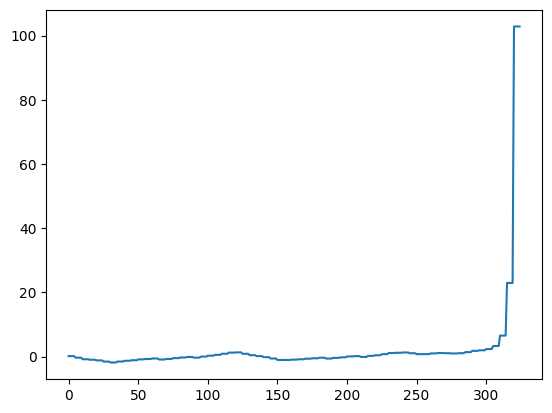

In [ ]:
tiempo = range(0,len(inflacion_exp_mip))
plt.plot(tiempo,np.log10(inflacion_exp_mip))asas